In [1]:
import re
import json
import tarfile
import pandas as pd
import seaborn as sns
from imdb import IMDb
from scipy import stats
import matplotlib.pyplot as plt

In [27]:
#Data preparation using only the CMU dataset as it is
path = 'MovieSummaries\\'
df_plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', names = ['WikipediaMovieID', 'PlotSummaries'], index_col = ['WikipediaMovieID'])
df_character = pd.read_csv("MovieSummaries/character.metadata.tsv", sep='\t', names = ['WikipediaMovieID', 'FreebaseMovieID', 'MovieReleaseDate', 'CharacterName', 
                                                                     'ActorDateOfBirth', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 
                                                                     'ActorName', 'ActorAgeAtMovieRelease','FreebaseCharacter', 
                                                                     'FreebaseCharacterID', 'FreebaseActorID'], index_col = ['WikipediaMovieID'])
df_movies = pd.read_csv("MovieSummaries/movie.metadata.tsv", sep='\t', header = None, names = ['WikipediaMovieID', 'FreebaseMovieID', 'MovieName', 
                                                                                       'MovieReleaseDate', 'MovieBoxOfficeRevenue',
                                                                                       'MovieRuntime', 'MovieLanguages', 'MovieCountries',
                                                                                       'MovieGenres'], index_col = ['WikipediaMovieID'])


def get_first(mapping):
    mapping = json.loads(mapping)
    if mapping:
        return next(iter(mapping.values()))
    return None

def replace(text):
    return str(text).replace(" Language", "").replace(" language", "")

# Apply the function to get the first country name
df_movies['MovieCountries']= df_movies['MovieCountries'].apply(get_first)
df_movies['MovieLanguages']= df_movies['MovieLanguages'].apply(get_first)
df_movies['MovieLanguages']= df_movies['MovieLanguages'].apply(replace)
df_movies['MovieGenres']= df_movies['MovieGenres'].apply(get_first)
df_movies['MovieReleaseDate'] = pd.to_datetime(df_movies['MovieReleaseDate'], format='%Y-%m-%d', errors='coerce')


print(f'Size of df_movies = {len(df_movies)}')
print(f'Size of df_plot_summaries = {len(df_plot_summaries)}')
print(f'Size of df_character = {len(df_character)}')

Size of df_movies = 81741
Size of df_plot_summaries = 42303
Size of df_character = 450669


The percentage of missing data in MovieReleaseDate column =   51.83%
The percentage of missing data in MovieGenres column =   2.81%
The percentage of missing data in MovieBoxOfficeRevenue column =   89.72%


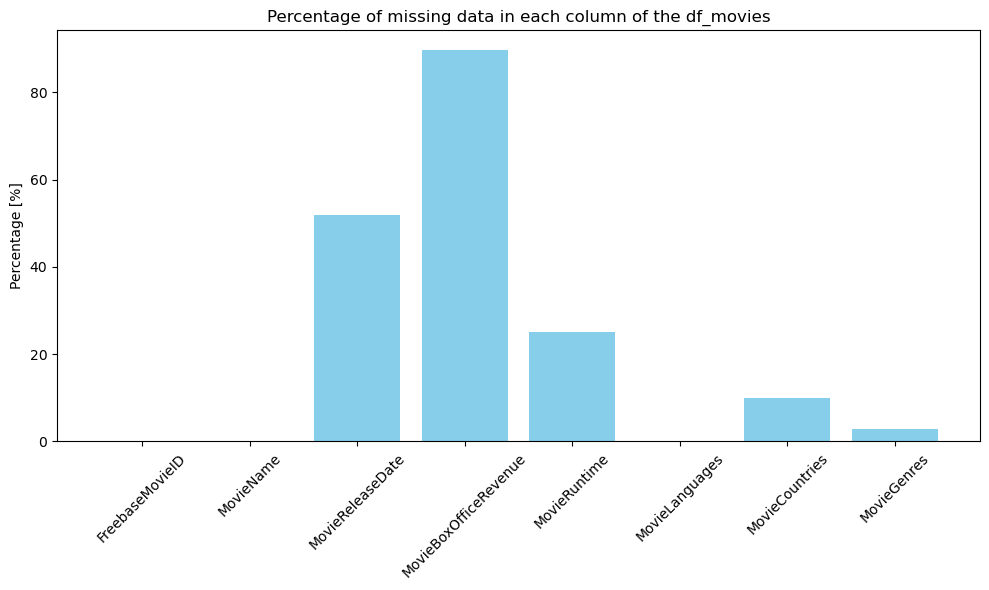

In [3]:
# Evaluate the percentage of missing data in relevant columns of df_movies
df_missing_data = (df_movies.isna().sum() / len(df_movies) ) * 100
missing_releaseDate_data = (df_movies.MovieReleaseDate.isna().sum() / len(df_movies) ) * 100
missing_genres_date = (df_movies.MovieGenres.isna().sum() / len(df_movies) ) * 100
missing_BOR_date = (df_movies.MovieBoxOfficeRevenue.isna().sum() / len(df_movies) ) * 100
print(f"The percentage of missing data in MovieReleaseDate column =  {missing_releaseDate_data: .2f}%")
print(f"The percentage of missing data in MovieGenres column =  {missing_genres_date: .2f}%")
print(f"The percentage of missing data in MovieBoxOfficeRevenue column =  {missing_BOR_date: .2f}%")
#
plt.figure(figsize=(10, 6))
plt.bar(df_missing_data.index, df_missing_data.values, color='skyblue')
plt.ylabel("Percentage [%]")
plt.title("Percentage of missing data in each column of the df_movies");
plt.xticks(rotation=45)
plt.tight_layout()

The percentage of missing data in MovieReleaseDate column of df_character =   12.23%


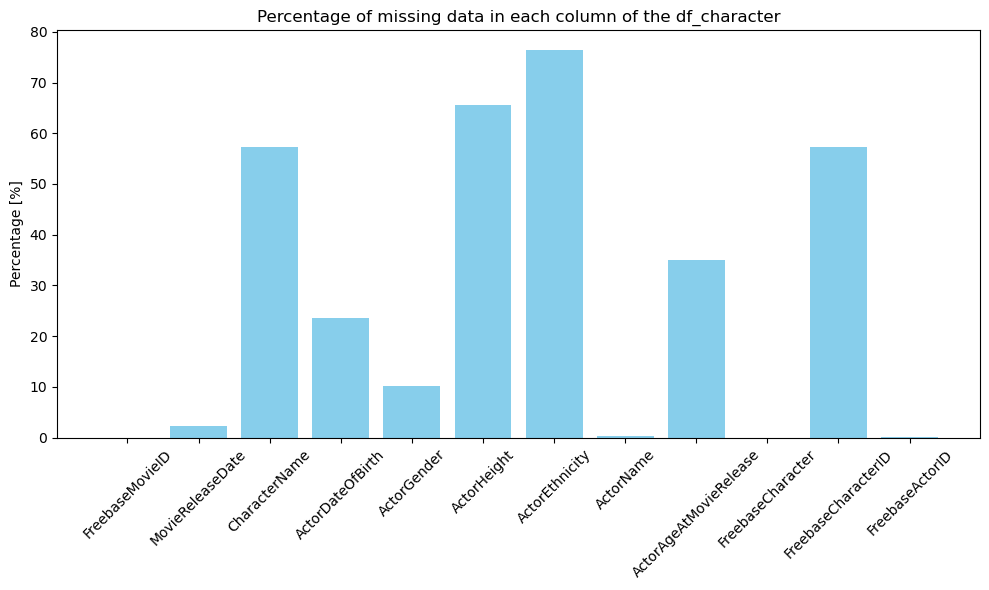

In [4]:
# Evaluate the percentage of missing data in relevant columns of df_characters
df_missing_character_data = (df_character.isna().sum() / len(df_character) ) * 100
missing_releaseDate_in_character_data = (df_character.MovieReleaseDate.isna().sum() / len(df_movies) ) * 100
print(f"The percentage of missing data in MovieReleaseDate column of df_character =  {missing_releaseDate_in_character_data: .2f}%")
plt.figure(figsize=(10, 6))
plt.bar(df_missing_character_data.index, df_missing_character_data.values, color='skyblue')
plt.ylabel("Percentage [%]")
plt.title("Percentage of missing data in each column of the df_character");
plt.xticks(rotation=45)
plt.tight_layout()

*******************************************************************************************************************************
#### We will merge the CMU dataframe with the IMDB non-commercial dataset (https://developer.imdb.com/non-commercial-datasets/) that includes ratings and other relevants informations about movies.
*******************************************************************************************************************************

In [23]:
#IMDB dataset downloaded from https://developer.imdb.com/non-commercial-datasets/
#***********************************************************
df_basics = pd.read_csv("title.basics.tsv/data.tsv", sep='\t')
print(len(df_basics))
display(df_basics.head())
df_basics = df_basics[df_basics['titleType'] == 'movie']
#***********************************************************
df_ratings = pd.read_csv("title.ratings.tsv/data.tsv", sep='\t')
print(len(df_ratings[df_ratings.averageRating.isna()]))
display(df_ratings)

C:\Users\koami\AppData\Local\Temp\ipykernel_17596\3148074519.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_basics = pd.read_csv("title.basics.tsv/data.tsv", sep='\t')


10316950


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


0


,tconst,averageRating,numVotes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1912
3,tt0000004,5.5,178
4,tt0000005,6.2,2692
...,...,...,...
1369205,tt9916730,7.6,11
1369206,tt9916766,7.0,22
1369207,tt9916778,7.2,36
1369208,tt9916840,8.8,6


In [25]:
#***********************************************************
# Merging the two dataframe : df_basics and df_ratings
# The new merged dataset contains the ratings, title, genres, IMDB ID, etc...
df_IMDb_merged = pd.merge(df_basics, df_ratings, how='right', on='tconst')
df_IMDb_merged = df_IMDb_merged[~df_IMDb_merged['titleType'].isna()]
df_IMDb_merged['MovieName'] = df_IMDb_merged['primaryTitle']
df_IMDb_merged.rename(columns={'startYear':'MovieReleaseDate'}, inplace =True)
df_IMDb_merged.rename(columns={'tconst':'IMDbID'}, inplace=True)
df_IMDb_merged['MovieReleaseDate'] = pd.to_datetime(df_IMDb_merged['MovieReleaseDate'], errors='coerce').dt.year.astype('Int64')
#df_IMDb_merged = df_IMDb_merged.rename(columns={'primaryTitle': 'MovieName'})
display(df_IMDb_merged)

,IMDbID,titleType,primaryTitle,originalTitle,isAdult,MovieReleaseDate,endYear,runtimeMinutes,genres,averageRating,numVotes,MovieName
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207,Miss Jerry
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,484,The Corbett-Fitzsimmons Fight
333,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15,Bohemios
365,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,855,The Story of the Kelly Gang
373,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.0,21,The Prodigal Son
...,...,...,...,...,...,...,...,...,...,...,...,...
1369177,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1448,Il talento del calabrone
1369181,tt9916362,movie,Coven,Akelarre,0,2020,\N,92,"Drama,History",6.4,5609,Coven
1369186,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,\N,"Adventure,History,War",3.5,17,The Secret of China
1369192,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,Drama,8.6,7,Kuambil Lagi Hatiku


In [28]:
#Removing the NaN from the CMU dataset df_movies
df_movies_nona = df_movies[~df_movies['MovieReleaseDate'].isna()]
#
df_movies_nona['MovieReleaseDate'] = pd.to_datetime(df_movies_nona['MovieReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.year
#***********************************************************
#Merging the two CMU datasets df_movies and df_plot_summaries
df_movies_nona = pd.merge(df_movies_nona, df_plot_summaries, how='left', on ='WikipediaMovieID')
display(df_movies_nona)

C:\Users\koami\AppData\Local\Temp\ipykernel_17596\3680476939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_nona['MovieReleaseDate'] = pd.to_datetime(df_movies_nona['MovieReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.year


,FreebaseMovieID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,PlotSummaries
WikipediaMovieID,,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,English,United States of America,Thriller,"Set in the second half of the 22nd century, th..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,English,United States of America,Mystery,NaN
13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,Silent film,United States of America,Short Film,NaN
10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,English,United States of America,Musical,NaN
6631279,/m/0gffwj,Little city,1997,NaN,93.0,English,United States of America,Romantic comedy,"Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...,...,...,...,...
32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,Russian,Russia,Sports,NaN
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,NaN,120.0,English,United States of America,Drama,Two former National Oceanic Atmospheric Admini...
34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,English,Ireland,Biographical film,{{No plot}} This film follows 12 years in the ...


In [29]:
#***********************************************************
#The CMU dataset is merged here with the IMDB non-commercial dataset
df = df_movies_nona.merge(df_IMDb_merged[['IMDbID', 'MovieName', 'averageRating', 'primaryTitle', 'MovieReleaseDate', 'genres']], how= 'outer', on = ['MovieName', 'MovieReleaseDate'])
#Missing ratings data are removed from the merged dataframe
df = df[~df['averageRating'].isna()]
df.drop(['FreebaseMovieID', 'MovieGenres', 'primaryTitle'], axis=1, inplace=True)
new_column_order = ['IMDbID'] + [col for col in df.columns if col != 'IMDbID']
df = df[new_column_order]
df = df[~df.PlotSummaries.isna()]
df.to_csv('cmu_merged_with_imdb.csv', index=False)
print(f"The size of the merged dataset is {len(df)}")
display(df)

The size of the merged dataset is 14950


,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres
0,tt0228333,Ghosts of Mars,2001,14010832.0,98.0,English,United States of America,"Set in the second half of the 22nd century, th...",4.9,"Action,Horror,Sci-Fi"
5,tt0097499,Henry V,1989,10161099.0,137.0,English,United Kingdom,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,7.5,"Biography,Drama,History"
6,tt0058331,Mary Poppins,1964,102272727.0,139.0,English,United States of America,The film opens with Mary Poppins perched in a...,7.8,"Comedy,Family,Fantasy"
13,tt0255819,Baby Boy,2001,29381649.0,123.0,English,United States of America,A young 20-year-old named Jody lives with his...,6.4,"Crime,Drama,Romance"
14,tt0367546,Bindiya Chamkegi,1984,NaN,NaN,Hindi,India,Shalini 'Shalu' lives a wealthy lifestyle with...,4.9,"Comedy,Family"
...,...,...,...,...,...,...,...,...,...,...
39575,tt0107057,Guilty as Sin,1993,22886222.0,107.0,None,United States of America,Jennifer Haines is an up-and-coming Chicago a...,5.7,"Crime,Drama,Thriller"
39576,tt0372937,Into the Mirror,2003,NaN,113.0,Korean,South Korea,After accidentally causing the death of his pa...,6.4,"Action,Fantasy,Horror"
39577,tt0109922,Gopi Kishan,1994,NaN,NaN,Hindi,India,Kishan killed a man in his childhood when the...,5.8,"Action,Comedy,Drama"
39580,tt0033660,The Ghost Train,1941,NaN,82.0,English,United Kingdom,{{plot}} The film opens with a Great Western e...,6.2,"Comedy,Horror"


***************************************************************************************************************
### Research question Q5 : How does the critical reception and recognition of movies with explicit socio-political content compare to those focused on entertainment or aesthetics?
***************************************************************************************************************

In [32]:
#******************************************************************************************************************************************
#Add a new column to the dataset to distinguish socio-political movies from the non-socio-political movies
#******************************************************************************************************************************************

# Here, we define keywords associated with socio-political themes
socio_political_keywords = ['politics', 'social justice', 'activism', 'protest', 'war', 'inequality']

# Function to categorize movies
def categorize_movie(row):
    # Check if any of the socio-political keywords appear in the plot summary
    plot_summary = row['PlotSummaries'].lower() if 'PlotSummaries' in row else ''
    
    for keyword in socio_political_keywords:
        if keyword in plot_summary:
            return 'Socio-Political'
    
    # Check if any of the socio-political keywords appear in the genres
    genres = row['Genre'].lower() if 'Genre' in row else ''
    genre_list = genres.split(',')  # Split the concatenated genres into a list
    
    for genre in genre_list:
        for keyword in socio_political_keywords:
            if keyword in genre:
                return 'Socio-Political'
    
    return 'Non Socio-Political'

# Create a new column 'Category' to store the categorization
df['Category'] = df.apply(categorize_movie, axis=1)

# Now, df contains a 'Category' column indicating whether a movie is socio-political or Non Socio-Political-focused

# The new updated dataset is saved to a new CSV file
output_path = 'cmu_merged_with_imdb.csv'
df.to_csv(output_path, index=False)

# Count the number of movies in each category
category_counts = df['Category'].value_counts()
print(category_counts)


display(df)

Category
Non Socio-Political    8442
Socio-Political        6508
Name: count, dtype: int64


,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres,Category
0,tt0228333,Ghosts of Mars,2001,14010832.0,98.0,English,United States of America,"Set in the second half of the 22nd century, th...",4.9,"Action,Horror,Sci-Fi",Non Socio-Political
5,tt0097499,Henry V,1989,10161099.0,137.0,English,United Kingdom,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,7.5,"Biography,Drama,History",Non Socio-Political
6,tt0058331,Mary Poppins,1964,102272727.0,139.0,English,United States of America,The film opens with Mary Poppins perched in a...,7.8,"Comedy,Family,Fantasy",Socio-Political
13,tt0255819,Baby Boy,2001,29381649.0,123.0,English,United States of America,A young 20-year-old named Jody lives with his...,6.4,"Crime,Drama,Romance",Socio-Political
14,tt0367546,Bindiya Chamkegi,1984,NaN,NaN,Hindi,India,Shalini 'Shalu' lives a wealthy lifestyle with...,4.9,"Comedy,Family",Non Socio-Political
...,...,...,...,...,...,...,...,...,...,...,...
39575,tt0107057,Guilty as Sin,1993,22886222.0,107.0,None,United States of America,Jennifer Haines is an up-and-coming Chicago a...,5.7,"Crime,Drama,Thriller",Socio-Political
39576,tt0372937,Into the Mirror,2003,NaN,113.0,Korean,South Korea,After accidentally causing the death of his pa...,6.4,"Action,Fantasy,Horror",Non Socio-Political
39577,tt0109922,Gopi Kishan,1994,NaN,NaN,Hindi,India,Kishan killed a man in his childhood when the...,5.8,"Action,Comedy,Drama",Socio-Political
39580,tt0033660,The Ghost Train,1941,NaN,82.0,English,United Kingdom,{{plot}} The film opens with a Great Western e...,6.2,"Comedy,Horror",Socio-Political


Mean Ratings:
Category
Non Socio-Political    6.120137
Socio-Political        6.422895
Name: averageRating, dtype: float64

Median Ratings:
Category
Non Socio-Political    6.3
Socio-Political        6.5
Name: averageRating, dtype: float64
Frequency of Ratings in Socio-Political Category:
6        7.8
13       6.4
41       6.5
53       6.7
59       5.7
        ... 
39557    6.4
39573    8.2
39575    5.7
39577    5.8
39580    6.2
Name: averageRating, Length: 6508, dtype: float64

Frequency of Ratings in Non Socio-Politicals Category:
0        4.9
5        7.5
14       4.9
27       6.0
29       3.9
        ... 
39566    6.3
39567    5.1
39574    6.7
39576    6.4
39583    6.8
Name: averageRating, Length: 8442, dtype: float64


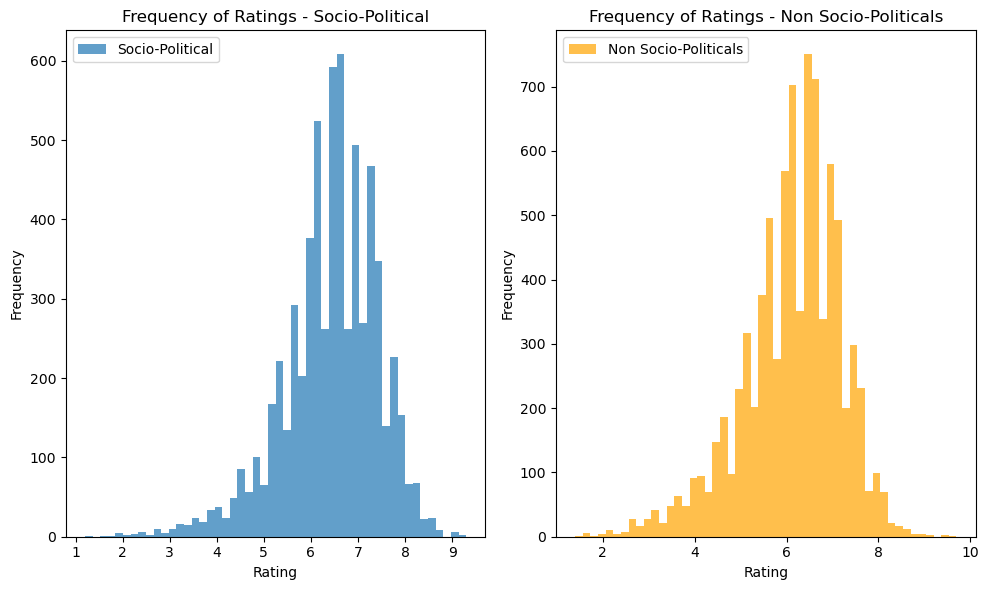

In [37]:
#*******************************************************************************************************************************************
#Ratings Analysis: Compare the average ratings of movies in both categories. Look at metrics like mean, median, and distribution of ratings.
#*******************************************************************************************************************************************
# Calculate the mean and median ratings for each category
mean_ratings = df.groupby('Category')['averageRating'].mean()
median_ratings = df.groupby('Category')['averageRating'].median()

print("Mean Ratings:")
print(mean_ratings)

print("\nMedian Ratings:")
print(median_ratings)

# Calculate frequency of each rating for 'Socio-Political' category
socio_political_frequency = df[df['Category'] == 'Socio-Political']['averageRating']

# Calculate frequency of each rating for 'Non Socio-Political' category
Non_Socio_Political_frequency = df[df['Category'] == 'Non Socio-Political']['averageRating']

print("Frequency of Ratings in Socio-Political Category:")
print(socio_political_frequency)

print("\nFrequency of Ratings in Non Socio-Politicals Category:")
print(Non_Socio_Political_frequency)

# Plotting histograms
plt.figure(figsize=(10, 6))
bins = 50
# Histogram for Socio-Political movies
plt.subplot(1, 2, 1)
plt.hist(socio_political_frequency, bins=bins, alpha=0.7, label='Socio-Political')
plt.title('Frequency of Ratings - Socio-Political')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

# Histogram for Non Socio-Politicals movies
plt.subplot(1, 2, 2)
plt.hist(Non_Socio_Political_frequency, bins=bins, alpha=0.7, color='orange', label='Non Socio-Politicals')
plt.title('Frequency of Ratings - Non Socio-Politicals')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

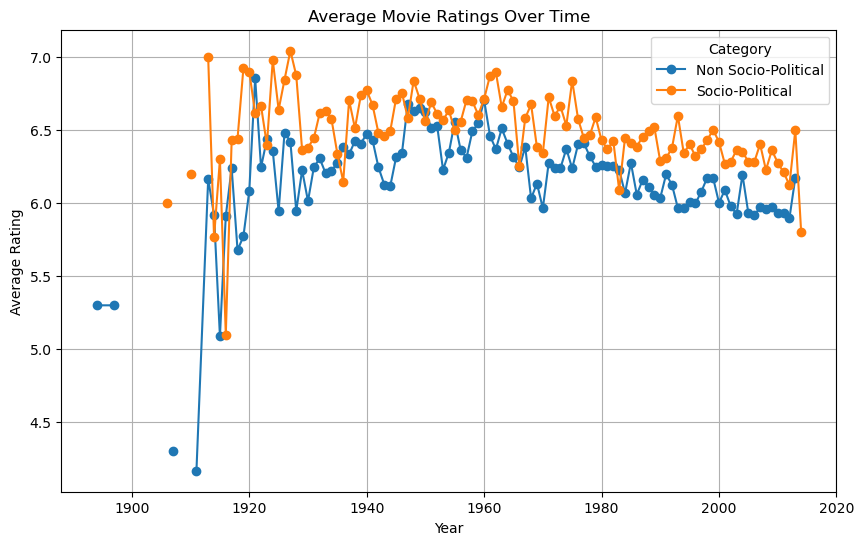

In [38]:
#*****************************************************************************************************************
#Trend Analysis Over Time: Analyze how the critical reception of movies in the Socio-political and Non Socio-Political categories has changed over time.
#*****************************************************************************************************************

# Group by ReleaseYear and Category, then calculate the mean rating for each group
mean_ratings_over_time = df.groupby(['MovieReleaseDate', 'Category'])['averageRating'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 6))
mean_ratings_over_time.plot(kind='line', marker='o', title='Average Movie Ratings Over Time', ylabel='Average Rating', xlabel='Year', grid=True, figsize=(10, 6))

plt.legend(title='Category')
plt.show()


In [39]:
#*****************************************************************************************************************************************************
#Statistical Tests:Conduct statistical tests (like t-tests or ANOVA) to see if there are significant differences in ratings between the two categories.
#*****************************************************************************************************************************************************

# Filter the ratings for each category
socio_political_ratings = df[df['Category'] == 'Socio-Political']['averageRating']
non_socio_political_ratings = df[df['Category'] == 'Non Socio-Political']['averageRating']

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(socio_political_ratings, non_socio_political_ratings, nan_policy='omit')

print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Interpret the p-value
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in ratings between the two categories.")
else:
    print("There is no significant difference in ratings between the two categories.")


T-Statistic: 17.43336048257116
P-Value: 2.1361098442919624e-67
There is a significant difference in ratings between the two categories.


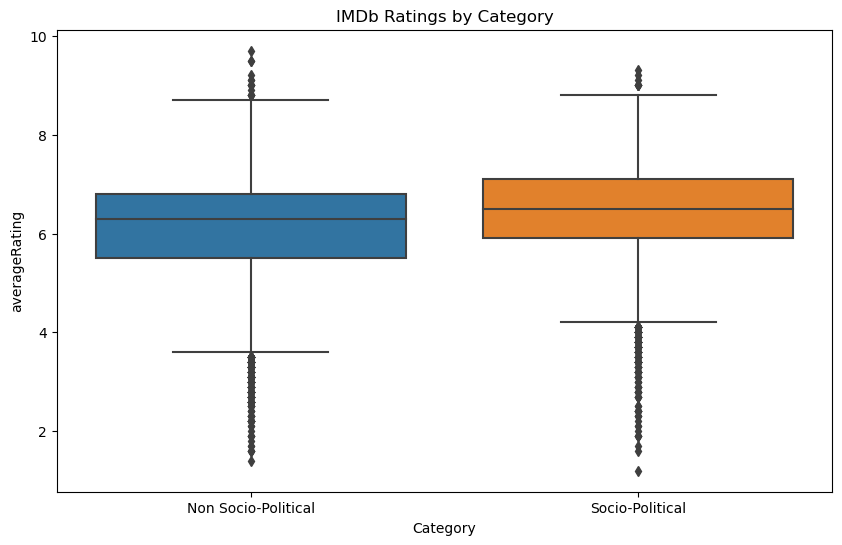

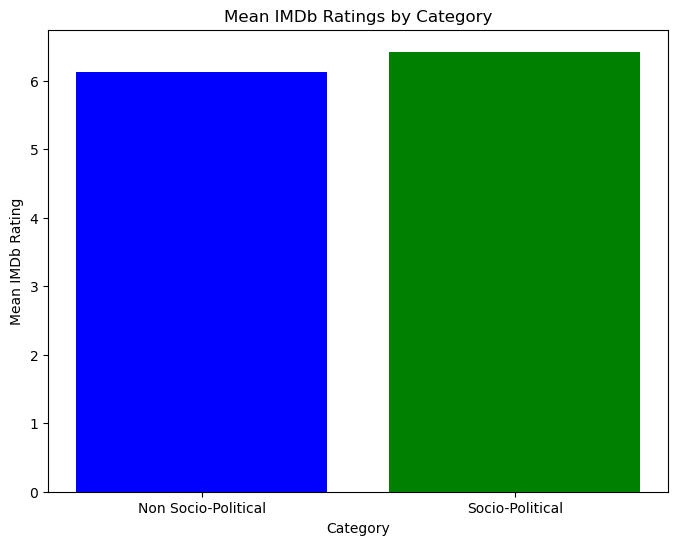

T-Statistic: 17.59321774338521
P-Value: 1.4422005814349149e-68
The difference in IMDb ratings is statistically significant.
Mean IMDb Rating (Socio-Political): 6.422894898586355
Mean IMDb Rating (Entertainment/Aesthetics): 6.12013740819711
Standard Deviation IMDb Rating (Socio-Political): 1.0103664816536573
Standard Deviation IMDb Rating (Non Socio-Political): 1.0843523423874841


In [40]:
#**********************************************************************************************************
#Create different plots to visualize the difference between the two categories
#**********************************************************************************************************

# Separate movies into two categories
socio_political_movies = df[df['Category'] == 'Socio-Political']
non_socio_political_movies = df[df['Category'] == 'Non Socio-Political']

# Create box plots to visualize IMDb ratings for each category
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='averageRating', data=df)
plt.title('IMDb Ratings by Category')
plt.show()

# Group the data by category and calculate the mean IMDb rating for each category
category_means = df.groupby('Category')['averageRating'].mean().reset_index()

# Create a bar chart to visualize mean IMDb ratings by category
plt.figure(figsize=(8, 6))
plt.bar(category_means['Category'], category_means['averageRating'], color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('Mean IMDb Rating')
plt.title('Mean IMDb Ratings by Category')
plt.xticks(rotation=0)
plt.show()

# Perform a t-test to compare IMDb ratings
t_statistic, p_value = stats.ttest_ind(socio_political_movies['averageRating'], non_socio_political_movies['averageRating'], equal_var=False)

# Print the results of the t-test
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

# Determine if the difference is statistically significant
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print('The difference in IMDb ratings is statistically significant.')
else:
    print('There is no statistically significant difference in IMDb ratings.')

# You can also calculate and print the means and standard deviations for each category
mean_socio_political = socio_political_movies['averageRating'].mean()
mean_non_socio_political = non_socio_political_movies['averageRating'].mean()
std_socio_political = socio_political_movies['averageRating'].std()
std_non_socio_political = non_socio_political_movies['averageRating'].std()

print(f'Mean IMDb Rating (Socio-Political): {mean_socio_political}')
print(f'Mean IMDb Rating (Entertainment/Aesthetics): {mean_non_socio_political}')
print(f'Standard Deviation IMDb Rating (Socio-Political): {std_socio_political}')
print(f'Standard Deviation IMDb Rating (Non Socio-Political): {std_non_socio_political}')


The statistical analysis provides strong evidence to conclude that movies with explicit socio-political content are received differently in terms of ratings when compared to movies focused on entertainment or aesthetics (non socio-political content). On average, movies with socio-political content tend to have slightly higher ratings than those in the entertainment/aesthetics category, and this difference is statistically significant. Additionally, the smaller standard deviation for Socio-Political movies suggests that they may also have more consistent ratings compared to Entertainment/Aesthetics movies.

In [16]:
#*********************************************************************************************************************************
#Test with another dataset : Kaggle dataset
#*********************************************************************************************************************************

In [41]:
# Load the merged dataset CMU + Kaggle
kaggle_df = pd.read_csv("MovieSummaries/kaggle_dataset/merged_df.csv", sep=',')
pd.set_option('display.max_columns', None)
print(f'Size of df_movies = {len(kaggle_df)}')
display(kaggle_df.sample(5))
rating = pd.read_csv('MovieSummaries/kaggle_dataset/ratings.csv')
links = pd.read_csv('MovieSummaries/kaggle_dataset/links.csv')
movies = pd.read_csv('MovieSummaries/kaggle_dataset/movies_metadata.csv')
merged_df = pd.read_csv('MovieSummaries/kaggle_dataset/merged_df.csv')
display(len(rating))
display(len(links))
display(len(movies))
display(merged_df.sample(5))

Size of df_movies = 15409


,movieId,rating,imdb_id,tmdbId,adult,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
11441,158900,3.666667,5066870,361745.0,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",http://www.hallmarkchannel.com/autumn-dreams,361745,en,Autumn Dreams,"With plans to leave their small town, teenage ...",2.212724,/AueEG08032KOI46xWYO02edshAW.jpg,"[{'name': 'Reunion Pictures', 'id': 3039}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-10-03,0.0,0.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Autumn Dreams,False,6.9,14.0
11220,157843,0.750000,3422000,339749.0,False,NaN,0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",NaN,339749,ja,ＳＭガールズ セイバーマリオネットＲ,"Jr., the heir of Romana and his battle sabers ...",0.001258,/79nRvqKuTDQNVRqSC5Bq7Z4LzXb.jpg,"[{'name': 'ANIMATE', 'id': 13064}, {'name': 'Z...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",1995-05-21,0.0,30.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Saber Marionette R,False,0.0,0.0
10272,151631,3.812500,4940780,378350.0,False,NaN,1200000,"[{'id': 18, 'name': 'Drama'}]",NaN,378350,fi,Jättiläinen,A young and ambitious civil servant Jussi find...,0.842808,/yCuODB2bMp0R2T8v0K9QTdGntJw.jpg,"[{'name': 'Helsinki Filmi Oy', 'id': 6159}]","[{'iso_3166_1': 'FI', 'name': 'Finland'}]",2016-01-22,0.0,97.0,"[{'iso_639_1': 'fi', 'name': 'suomi'}]",Released,A story worth a half billion euros.,The Mine,False,7.1,6.0
418,72131,3.323529,1477715,13576.0,False,NaN,60000000,"[{'id': 10402, 'name': 'Music'}, {'id': 99, 'n...",http://www.thisisit-movie.com,13576,en,Michael Jackson's This Is It,"A compilation of interviews, rehearsals and ba...",7.015456,/4ZgT8FRJxxpG0mgOIPeCgjzAsBR.jpg,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-10-28,0.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Like You've Never Seen Him Before,This Is It,False,6.7,253.0
14916,174595,1.500000,4393278,314952.0,False,"{'id': 315091, 'name': 'Что Творят мужчины! (К...",2000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,314952,ru,Что творят мужчины! 2,Four friends from the first movie are back in ...,1.485590,/bjrxYgVgTQFDpRhxH4DvJSpTyyY.jpg,"[{'name': 'Enjoy Movies', 'id': 9340}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2015-01-01,0.0,90.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,What Men Do! 2,False,2.2,5.0


C:\Users\koami\AppData\Local\Temp\ipykernel_17596\492505923.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('MovieSummaries/kaggle_dataset/movies_metadata.csv')


26024289

45843

45466

,movieId,rating,imdb_id,tmdbId,adult,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1267,85742,1.250000,1305897,81414.0,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,81414,es,Ingrid,NaN,0.022858,/blAwLZIwid6VRgcRlchEN6GKt7P.jpg,[],[],2010-04-30,0.0,0.0,[],NaN,NaN,Ingrid,False,0.0,0.0
9246,144924,3.000000,1424366,50086.0,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",NaN,50086,th,นางไม้,An urban husband and wife travel to the jungle...,0.546513,/fE6WDCfCoEARa5YYPeneToyqdlb.jpg,"[{'name': 'Fortissimo Films', 'id': 1615}]","[{'iso_3166_1': 'TH', 'name': 'Thailand'}]",2009-05-20,0.0,91.0,"[{'iso_639_1': 'th', 'name': 'ภาษาไทย'}]",Released,NaN,Nymph,False,6.9,7.0
6898,132048,2.625000,3560546,294083.0,False,NaN,0,"[{'id': 27, 'name': 'Horror'}]",NaN,294083,en,Dead Girls,Dead Girls is a horror anthology featuring thr...,0.380439,/4wCdTu4ed2r1GkTixCANyxdQ5cF.jpg,[],[],2014-09-21,0.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Beauty, Brains, Blood.",Dead Girls,False,2.5,2.0
8782,142586,2.666667,2215673,322443.0,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",NaN,322443,de,The Timber,"In the wild west, two brothers embark on a jou...",2.395158,/vLLyRSEYXhhYDglYiqhmdTsZ0LU.jpg,"[{'name': 'ANA Media', 'id': 21817}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-27,0.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Fortunes will be made, lives will be lost.",The Timber,False,4.1,17.0
3936,107085,3.055556,1571401,115023.0,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,115023,de,Die Vermessung der Welt,"Germany in the early 19th century. ""Die Vermes...",5.047333,/wnkE7gkXhyKDHkRtnQVLEaOAiVT.jpg,"[{'name': 'Boje Buck Produktion', 'id': 230}, ...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2012-10-24,0.0,127.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Measuring the World,False,5.6,30.0


In [42]:
#Using the kaggle df:
columns_to_keep = ['imdb_id', 'title', 'genres', 'rating', 'release_date', 'revenue']
df_kaggle = merged_df[columns_to_keep]
df_kaggle.rename(columns={'title':'MovieName'}, inplace=True)
df_kaggle.rename(columns={'release_date':'MovieReleaseDate'}, inplace=True)
df_kaggle['MovieReleaseDate'] = pd.to_datetime(df_kaggle['MovieReleaseDate'], errors='coerce').dt.year.astype('Int64')
df_kaggle = df_movies_nona.merge(df_kaggle[['MovieName', 'MovieReleaseDate', 'rating', 'revenue', 'genres']], how= 'outer', on = ['MovieName', 'MovieReleaseDate'])
df_kaggle = df_kaggle[~df_kaggle.PlotSummaries.isna()]
df_kaggle = df_kaggle[~df_kaggle.MovieReleaseDate.isna()]
df_kaggle = df_kaggle[~df_kaggle.genres.isna()]
df_kaggle = df_kaggle[~df_kaggle.rating.isna()]
df_kaggle

C:\Users\koami\AppData\Local\Temp\ipykernel_17596\462364683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kaggle.rename(columns={'title':'MovieName'}, inplace=True)
C:\Users\koami\AppData\Local\Temp\ipykernel_17596\462364683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kaggle.rename(columns={'release_date':'MovieReleaseDate'}, inplace=True)
C:\Users\koami\AppData\Local\Temp\ipykernel_17596\462364683.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,FreebaseMovieID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,PlotSummaries,rating,revenue,genres
43,/m/04mnqv6,33 Scenes from Life,2008,NaN,100.0,Polish,Poland,Drama,"The Polish artist Julia and her husband Piotr,...",3.437500,0.0,"[{'id': 18, 'name': 'Drama'}]"
52,/m/0h54gth,ChromeSkull: Laid to Rest 2,2011,NaN,93.0,English,United States of America,Horror,ChromeSkull: Laid to Rest 2 picks up three mon...,2.285714,0.0,"[{'id': 27, 'name': 'Horror'}]"
99,/m/0c037x9,Vanishing on 7th Street,2010,NaN,92.0,English,United States of America,Thriller,Paul is a projectionist in a Detroit theater ...,2.391129,1068682.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '..."
202,/m/0gkss5y,Cyrano Agency,2010,17917697.0,119.0,Korean,South Korea,Romantic comedy,"Lovelorn Kim Hyeon-gon , who has fallen for co...",3.500000,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
208,/m/0gf8mz8,Amador,2010,NaN,112.0,Spanish,Spain,Drama,Marcela is an immigrant woman with money diffi...,3.125000,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...
39233,/m/064pff0,Dug's Special Mission,2009,NaN,NaN,English,United States of America,Computer Animation,It is Dug's birthday. This Golden Retriever wi...,3.373333,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
39273,/m/05szw0d,Tales of Vesperia: The First Strike,2009,NaN,110.0,Japanese,Japan,Anime,{{plot}} The abnormal gushing of aer has cause...,3.050000,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
39327,/m/05zkcsk,Adam,2009,2549605.0,99.0,English,United States of America,Indie,Adam Raki is a young man with Asperger syndro...,3.650505,2277396.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."
39328,/m/0cn_63l,Norwegian Wood,2010,NaN,133.0,Japanese,Japan,Romantic drama,Toru Watanabe is a quiet and serious young man...,3.471429,17636261.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."


In [46]:
# Define keywords associated with socio-political themes
socio_political_keywords = ['politics', 'social justice', 'activism', 'protest', 'war', 'inequality']

# Function to categorize movies
def categorize_movie(row):
    # Check if any of the socio-political keywords appear in the plot summary
    plot_summary = row['PlotSummaries'].lower() if 'PlotSummaries' in row else ''
    
    for keyword in socio_political_keywords:
        if keyword in plot_summary:
            return 'Socio-Political'
    
    # Check if any of the socio-political keywords appear in the genres
    genres = row['Genre'].lower() if 'Genre' in row else ''
    genre_list = genres.split(',')  # Split the concatenated genres into a list
    
    for genre in genre_list:
        for keyword in socio_political_keywords:
            if keyword in genre:
                return 'Socio-Political'
    
    return 'Non Socio-Political'

# Create a new column 'Category' to store the categorization
df_kaggle['Category'] = df_kaggle.apply(categorize_movie, axis=1)

# Count the number of movies in each category
category_counts = df_kaggle['Category'].value_counts()
print(category_counts)

df_kaggle

Category
Non Socio-Political    908
Socio-Political        740
Name: count, dtype: int64


,FreebaseMovieID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,PlotSummaries,rating,revenue,genres,Category
43,/m/04mnqv6,33 Scenes from Life,2008,NaN,100.0,Polish,Poland,Drama,"The Polish artist Julia and her husband Piotr,...",3.437500,0.0,"[{'id': 18, 'name': 'Drama'}]",Non Socio-Political
52,/m/0h54gth,ChromeSkull: Laid to Rest 2,2011,NaN,93.0,English,United States of America,Horror,ChromeSkull: Laid to Rest 2 picks up three mon...,2.285714,0.0,"[{'id': 27, 'name': 'Horror'}]",Non Socio-Political
99,/m/0c037x9,Vanishing on 7th Street,2010,NaN,92.0,English,United States of America,Thriller,Paul is a projectionist in a Detroit theater ...,2.391129,1068682.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '...",Socio-Political
202,/m/0gkss5y,Cyrano Agency,2010,17917697.0,119.0,Korean,South Korea,Romantic comedy,"Lovelorn Kim Hyeon-gon , who has fallen for co...",3.500000,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Non Socio-Political
208,/m/0gf8mz8,Amador,2010,NaN,112.0,Spanish,Spain,Drama,Marcela is an immigrant woman with money diffi...,3.125000,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",Non Socio-Political
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39233,/m/064pff0,Dug's Special Mission,2009,NaN,NaN,English,United States of America,Computer Animation,It is Dug's birthday. This Golden Retriever wi...,3.373333,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Non Socio-Political
39273,/m/05szw0d,Tales of Vesperia: The First Strike,2009,NaN,110.0,Japanese,Japan,Anime,{{plot}} The abnormal gushing of aer has cause...,3.050000,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Socio-Political
39327,/m/05zkcsk,Adam,2009,2549605.0,99.0,English,United States of America,Indie,Adam Raki is a young man with Asperger syndro...,3.650505,2277396.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",Socio-Political
39328,/m/0cn_63l,Norwegian Wood,2010,NaN,133.0,Japanese,Japan,Romantic drama,Toru Watanabe is a quiet and serious young man...,3.471429,17636261.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",Non Socio-Political


Mean Ratings:
Category
Non Socio-Political    3.053758
Socio-Political        3.141859
Name: rating, dtype: float64

Median Ratings:
Category
Non Socio-Political    3.166667
Socio-Political        3.208718
Name: rating, dtype: float64
Frequency of Ratings in Socio-Political Category:
99       2.391129
281      3.659091
284      3.255572
388      3.379221
525      3.600000
           ...   
39107    2.899449
39137    2.750000
39150    3.965493
39273    3.050000
39327    3.650505
Name: rating, Length: 740, dtype: float64

Frequency of Ratings in Non Socio-Political Category:
43       3.437500
52       2.285714
202      3.500000
208      3.125000
242      3.142857
           ...   
39126    0.500000
39144    2.721311
39233    3.373333
39328    3.471429
39377    3.631579
Name: rating, Length: 908, dtype: float64


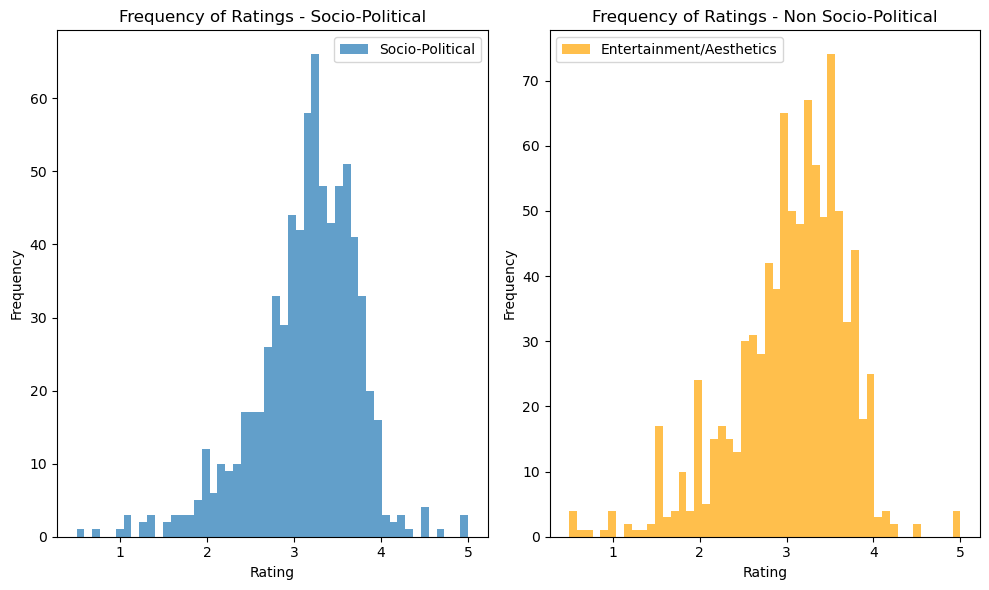

In [47]:
#Ratings Analysis: Compare the average ratings of movies in both categories. Look at metrics like mean, median, and distribution of ratings.

# Calculate the mean and median ratings for each category
mean_ratings = df_kaggle.groupby('Category')['rating'].mean()
median_ratings = df_kaggle.groupby('Category')['rating'].median()

print("Mean Ratings:")
print(mean_ratings)

print("\nMedian Ratings:")
print(median_ratings)

# Calculate frequency of each rating for 'Socio-Political' category
socio_political_frequency = df_kaggle[df_kaggle['Category'] == 'Socio-Political']['rating']

# Calculate frequency of each rating for 'Non Socio-Political' category
non_socio_political_frequency = df_kaggle[df_kaggle['Category'] == 'Non Socio-Political']['rating']

print("Frequency of Ratings in Socio-Political Category:")
print(socio_political_frequency)

print("\nFrequency of Ratings in Non Socio-Political Category:")
print(non_socio_political_frequency)

# Plotting histograms
plt.figure(figsize=(10, 6))
bins = 50
# Histogram for Socio-Political movies
plt.subplot(1, 2, 1)
plt.hist(socio_political_frequency, bins=bins, alpha=0.7, label='Socio-Political')
plt.title('Frequency of Ratings - Socio-Political')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

# Histogram for Non Socio-Political movies
plt.subplot(1, 2, 2)
plt.hist(non_socio_political_frequency, bins=bins, alpha=0.7, color='orange', label='Entertainment/Aesthetics')
plt.title('Frequency of Ratings - Non Socio-Political')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

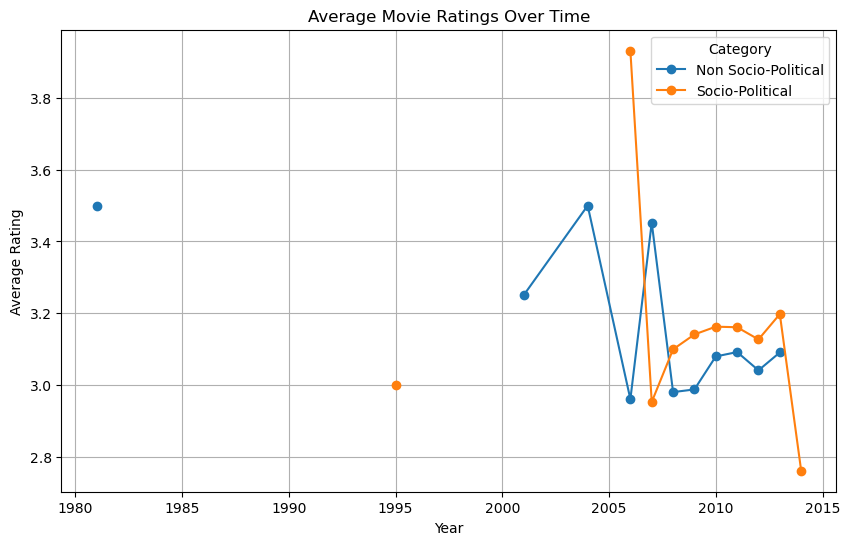

T-Statistic: 2.848590375672262
P-Value: 0.004445926189333631
There is a significant difference in ratings between the two categories.


In [49]:
#Trend Analysis Over Time: Analyze how the critical reception of movies in these categories has changed over time.

# Group by ReleaseYear and Category, then calculate the mean rating for each group
mean_ratings_over_time = df_kaggle.groupby(['MovieReleaseDate', 'Category'])['rating'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 6))
mean_ratings_over_time.plot(kind='line', marker='o', title='Average Movie Ratings Over Time', ylabel='Average Rating', xlabel='Year', grid=True, figsize=(10, 6))

plt.legend(title='Category')
plt.show()

# Filter the ratings for each category
socio_political_ratings = df_kaggle[df_kaggle['Category'] == 'Socio-Political']['rating']
non_socio_political_ratings = df_kaggle[df_kaggle['Category'] == 'Non Socio-Political']['rating']

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(socio_political_ratings, non_socio_political_ratings, nan_policy='omit')

print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Interpret the p-value
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in ratings between the two categories.")
else:
    print("There is no significant difference in ratings between the two categories.")

For the kaggle dataset we don't have enough data before the year 2000. However after 2000, we obtained just as for the cmu + IMDb dataset a significant difference in ratings between socio-political and non socio-political movies, confirming once again that socio-political movies are well recieved than non socio-political movies.